In [1]:
!pip install torchsummary
!pip install facenet-pytorch
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/aligned.zip
!unzip gdrive/MyDrive/emojistrans.zip

Streaming output truncated to the last 5000 lines.
  inflating: aligned/train_07288_aligned.jpg  
  inflating: aligned/train_07289_aligned.jpg  
  inflating: aligned/train_07290_aligned.jpg  
  inflating: aligned/train_07291_aligned.jpg  
  inflating: aligned/train_07292_aligned.jpg  
  inflating: aligned/train_07293_aligned.jpg  
  inflating: aligned/train_07294_aligned.jpg  
  inflating: aligned/train_07295_aligned.jpg  
  inflating: aligned/train_07296_aligned.jpg  
  inflating: aligned/train_07297_aligned.jpg  
  inflating: aligned/train_07298_aligned.jpg  
  inflating: aligned/train_07299_aligned.jpg  
  inflating: aligned/train_07300_aligned.jpg  
  inflating: aligned/train_07301_aligned.jpg  
  inflating: aligned/train_07302_aligned.jpg  
  inflating: aligned/train_07303_aligned.jpg  
  inflating: aligned/train_07304_aligned.jpg  
  inflating: aligned/train_07305_aligned.jpg  
  inflating: aligned/train_07306_aligned.jpg  
  inflating: aligned/train_07307_aligned.jpg  
  inflati

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import cv2 as cv
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from facenet_pytorch import MTCNN

In [3]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


In [4]:
X_Train = []
Y_Train = []
X_Test = []
Y_Test = []

labels = pd.read_csv("list_patition_label.txt", sep=" ", header=None)
for x in os.listdir("aligned/"):
  img_name = str(x)[:-12]
  if x.startswith("train"):
    X_Train.append(cv.imread("aligned/" + img_name + "_aligned.jpg"))
    label = labels[1][labels.index[labels[0] == img_name + ".jpg"].to_list()[0]]-1
    Y_Train.append(label)

  if x.startswith("test"):
    X_Test.append(cv.imread("aligned/" + img_name + "_aligned.jpg"))
    label =  labels[1][labels.index[labels[0] == img_name + ".jpg"].to_list()[0]]-1
    Y_Test.append(label)


In [5]:
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)
X_Test = np.array(X_Test)
Y_Test = np.array(Y_Test)

In [6]:
class FaceDataSet(Dataset):
  def __init__(self, imgs, labels):
    self.imgs = imgs
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    return transforms.functional.to_tensor(self.imgs[idx]), self.labels[idx]


trainloader = FaceDataSet(X_Train[0:10000], Y_Train[0:10000])
valloader = FaceDataSet(X_Train[10000:], Y_Train[10000:])
testloader = FaceDataSet(X_Test, Y_Test)

trainloader = DataLoader(trainloader, batch_size=32, shuffle=True)

valloader = DataLoader(valloader, batch_size=32, shuffle=True)

testloader = DataLoader(testloader, batch_size=32)

In [7]:
from torch.nn.modules.activation import ReLU6
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3,3), stride=1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv1_1 = nn.Conv2d(32, 32, (3,3), stride=1)
        self.batch1_1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d((2,2), stride=2)
        self.conv2 = nn.Conv2d(32, 64, (3,3), stride=1)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv2_1 = nn.Conv2d(64, 64, (3,3), stride=1)
        self.batch2_1 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d((2,2), stride=2)
        self.conv3 = nn.Conv2d(64, 128, (3,3), stride=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv3_1 = nn.Conv2d(128, 128, (3,3), stride=1)
        self.batch3_1 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, (3,3), stride=1)
        self.batch4 = nn.BatchNorm2d(256)
        self.conv4_1 = nn.Conv2d(256, 256, (3,3), stride=1)
        self.batch4_1 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 14 * 14, 7)
  
    def forward(self, x):
        x = x.to(device)
        relu = nn.ReLU()
        x = self.conv1(x)
        x = relu(self.batch1(x))
        x = self.conv1_1(x)
        x = relu(self.batch1_1(x))
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = relu(self.batch2(x))
        x = self.conv2_1(x)
        x = relu(self.batch2_1(x))
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = relu(self.batch3(x))
        x = self.conv3_1(x)
        x = relu(self.batch3_1(x))
        x = self.conv4(x)
        x = relu(self.batch4(x))
        x = self.conv4_1(x)
        x = relu(self.batch4_1(x))
        x = x.view(-1, 256 * 14 * 14) 
        x = self.fc1(x)
        return x

model = Network().to(device)
criterion = nn.CrossEntropyLoss()
print('Your network:')
print(summary(model, (3,100,100), device=device))

learning_rate = 1e-4
weight_decay = 1e-6
num_epoch = 15
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay)

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 98, 98]             896
       BatchNorm2d-2           [-1, 32, 98, 98]              64
            Conv2d-3           [-1, 32, 96, 96]           9,248
       BatchNorm2d-4           [-1, 32, 96, 96]              64
         MaxPool2d-5           [-1, 32, 48, 48]               0
            Conv2d-6           [-1, 64, 46, 46]          18,496
       BatchNorm2d-7           [-1, 64, 46, 46]             128
            Conv2d-8           [-1, 64, 44, 44]          36,928
       BatchNorm2d-9           [-1, 64, 44, 44]             128
        MaxPool2d-10           [-1, 64, 22, 22]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
      BatchNorm2d-12          [-1, 128, 20, 20]             256
           Conv2d-13          [-1, 128, 18, 18]         147,584
      BatchNorm2d-14     

In [8]:
#Some refactored code from hw5
%%time
def train(model, trainloader, valloader, num_epoch=10):
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device).float()
            label = label.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, label)
            running_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad(): 
        for batch, label in tqdm(loader):
            batch = batch.to(device).float()
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc

trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)
print("\n Evaluate on test set")
evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 313/313 [00:24<00:00, 12.76it/s]



 Epoch 1 loss:1.1181467583004279


100%|██████████| 313/313 [00:09<00:00, 34.02it/s]



 Evaluation accuracy: 0.7929

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.23it/s]



 Evaluation accuracy: 0.6763540290620872
-----------------Epoch = 2-----------------


100%|██████████| 313/313 [00:23<00:00, 13.13it/s]



 Epoch 2 loss:0.6833453750648437


100%|██████████| 313/313 [00:09<00:00, 34.62it/s]



 Evaluation accuracy: 0.8412

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.27it/s]



 Evaluation accuracy: 0.7040951122853368
-----------------Epoch = 3-----------------


100%|██████████| 313/313 [00:23<00:00, 13.20it/s]



 Epoch 3 loss:0.47332604748372453


100%|██████████| 313/313 [00:09<00:00, 32.75it/s]



 Evaluation accuracy: 0.9027

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.98it/s]



 Evaluation accuracy: 0.7040951122853368
-----------------Epoch = 4-----------------


100%|██████████| 313/313 [00:23<00:00, 13.24it/s]



 Epoch 4 loss:0.3022580930766777


100%|██████████| 313/313 [00:08<00:00, 35.23it/s]



 Evaluation accuracy: 0.9577

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.18it/s]



 Evaluation accuracy: 0.7247908410391898
-----------------Epoch = 5-----------------


100%|██████████| 313/313 [00:23<00:00, 13.31it/s]



 Epoch 5 loss:0.17516066937353283


100%|██████████| 313/313 [00:08<00:00, 35.40it/s]



 Evaluation accuracy: 0.9478

 Evaluate on validation set...


100%|██████████| 71/71 [00:01<00:00, 35.60it/s]



 Evaluation accuracy: 0.7129018053720828
-----------------Epoch = 6-----------------


100%|██████████| 313/313 [00:23<00:00, 13.26it/s]



 Epoch 6 loss:0.1270770059464077


100%|██████████| 313/313 [00:08<00:00, 34.98it/s]



 Evaluation accuracy: 0.9472

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.39it/s]



 Evaluation accuracy: 0.6961690885072656
-----------------Epoch = 7-----------------


100%|██████████| 313/313 [00:23<00:00, 13.24it/s]



 Epoch 7 loss:0.10716976864358631


100%|██████████| 313/313 [00:08<00:00, 34.83it/s]



 Evaluation accuracy: 0.9801

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.81it/s]



 Evaluation accuracy: 0.726552179656539
-----------------Epoch = 8-----------------


100%|██████████| 313/313 [00:23<00:00, 13.27it/s]



 Epoch 8 loss:0.08497075129228944


100%|██████████| 313/313 [00:08<00:00, 35.18it/s]



 Evaluation accuracy: 0.9909

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.05it/s]



 Evaluation accuracy: 0.7388815499779833
-----------------Epoch = 9-----------------


100%|██████████| 313/313 [00:23<00:00, 13.26it/s]



 Epoch 9 loss:0.06168527405793829


100%|██████████| 313/313 [00:08<00:00, 35.31it/s]



 Evaluation accuracy: 0.9901

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.18it/s]



 Evaluation accuracy: 0.7234698370761778
-----------------Epoch = 10-----------------


100%|██████████| 313/313 [00:23<00:00, 13.25it/s]



 Epoch 10 loss:0.06563871750792566


100%|██████████| 313/313 [00:09<00:00, 34.45it/s]



 Evaluation accuracy: 0.9843

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.41it/s]



 Evaluation accuracy: 0.7335975341259358
-----------------Epoch = 11-----------------


100%|██████████| 313/313 [00:23<00:00, 13.27it/s]



 Epoch 11 loss:0.06737896938846943


100%|██████████| 313/313 [00:08<00:00, 35.11it/s]



 Evaluation accuracy: 0.9919

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.87it/s]



 Evaluation accuracy: 0.7261118450022017
-----------------Epoch = 12-----------------


100%|██████████| 313/313 [00:23<00:00, 13.27it/s]



 Epoch 12 loss:0.055295929445486405


100%|██████████| 313/313 [00:08<00:00, 35.35it/s]



 Evaluation accuracy: 0.9914

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.07it/s]



 Evaluation accuracy: 0.7269925143108763
-----------------Epoch = 13-----------------


100%|██████████| 313/313 [00:23<00:00, 13.28it/s]



 Epoch 13 loss:0.061202505558800586


100%|██████████| 313/313 [00:08<00:00, 35.14it/s]



 Evaluation accuracy: 0.9789

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.26it/s]



 Evaluation accuracy: 0.7203874944958168
-----------------Epoch = 14-----------------


100%|██████████| 313/313 [00:23<00:00, 13.28it/s]



 Epoch 14 loss:0.05590560889193645


100%|██████████| 313/313 [00:08<00:00, 35.67it/s]



 Evaluation accuracy: 0.9786

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 35.35it/s]



 Evaluation accuracy: 0.7366798767062968
-----------------Epoch = 15-----------------


100%|██████████| 313/313 [00:23<00:00, 13.28it/s]



 Epoch 15 loss:0.04389495808689203


100%|██████████| 313/313 [00:08<00:00, 35.14it/s]



 Evaluation accuracy: 0.9898

 Evaluate on validation set...


100%|██████████| 71/71 [00:02<00:00, 34.80it/s]



 Evaluation accuracy: 0.7269925143108763
Done!

 Evaluate on test set


100%|██████████| 96/96 [00:02<00:00, 35.06it/s]


 Evaluation accuracy: 0.7480443285528031
CPU times: user 8min 32s, sys: 5.89 s, total: 8min 37s
Wall time: 8min 43s


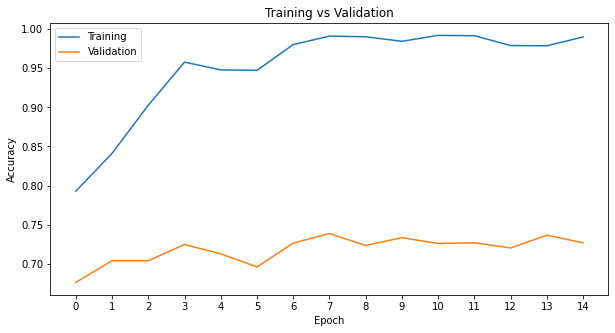

In [9]:
x = np.arange(num_epoch)
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation')
plt.gcf().set_size_inches(10, 5)
plt.savefig('TestVsVal.png', dpi=300)
plt.show()

In [10]:
#Open source code from google colab that lets us use the camera. Under insert/code snippets
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [11]:
#Off the shelf face detection CNN from py-torch as seen in the first code block pip.
face_detection_cnn = MTCNN()

<IPython.core.display.Javascript object>

Saved to photo.jpg


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


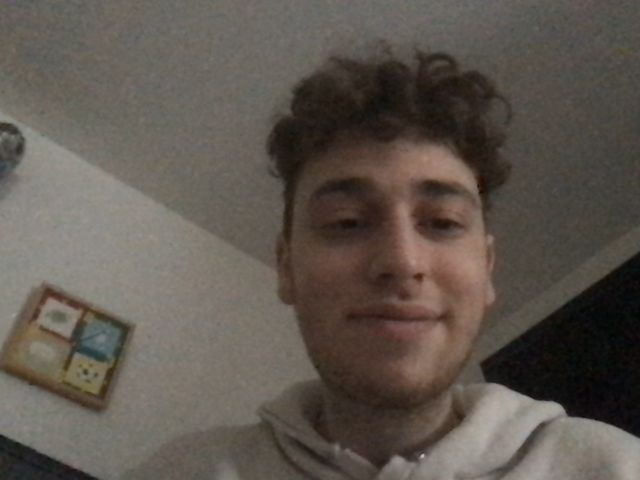

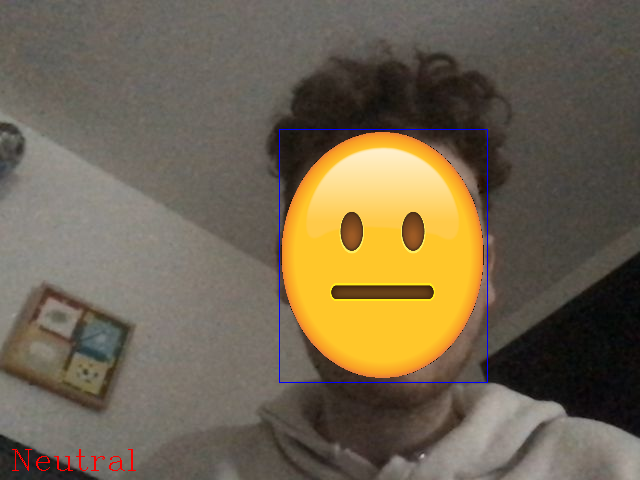

In [18]:
from torchvision.ops.boxes import box_area
from IPython.display import Image
try:

  classes = {0: "Surprise", 1: "Fear" ,2: "Disgust" ,3: "Happiness", 4: "Sadness", 5: "Anger" , 6: "Neutral"}

  filename = take_photo()
  print('Saved to {}'.format(filename))

  img = cv.imread(filename)
  box, prob = face_detection_cnn.detect(img)
  imgfull = img
  cv.rectangle(imgfull, (box[0,0], box[0,1]), (box[0,2], box[0,3]), (255,0,0), 1)

  img = imgfull[int(box[0,1]): int(box[0,3]), int(box[0,0]): int(box[0,2])]
  img = cv.resize(img, (100,100))
  img = transforms.functional.to_tensor(img)
  img = torch.unsqueeze(img, 0)
  output = model(img)
  pred = classes[torch.argmax(output).item()]

  emoji = cv.imread('emojistrans/' + pred + '.png')
  emoji = cv.resize(emoji, (int(np.abs(box[0,0] - box[0,2])), int(np.abs(box[0,1] - box[0,3]))))

  xend = int(box[0,0]) + emoji.shape[1]
  xstart = int(box[0,0])
  ystart = int(box[0,1])
  yend = int(box[0,1]) + emoji.shape[0]


  for x in range(emoji.shape[0]):
    for y in range(emoji.shape[1]):
      if emoji[x,y][0] == 0 and emoji[x,y][1] == 0 and emoji[x,y][2] == 0:
          emoji[x,y] = imgfull[x + ystart, y + xstart]


  imgfull[ystart:yend, xstart:xend] = emoji

  cv.putText(imgfull, pred, (10, imgfull.shape[0]-10), cv.FONT_HERSHEY_COMPLEX, 1, (0,0,255))

  cv.imwrite('prediction.png', imgfull)

  display(Image(filename))
  display(Image('prediction.png'))
except Exception as err:
  print(str(err))